In [1]:
from typing import Tuple, Callable, Optional

import numpy as np
import cv2
from glob import glob
import matplotlib.pyplot as plt
import functools

In [2]:
def load_calibration_params(path: str) -> Tuple[int, int, int, int, int, int]:
    calibration_npz = np.load(path)
    mtx = calibration_npz["mtx"]

    if "pre_img_dimensions" in calibration_npz:
        pre_img_dimensions = calibration_npz["pre_img_dimensions"]
    else:
        pre_img_dimensions = (int(mtx[0][2] * 2), int(mtx[1][2] * 2))

    return (
        mtx[0][0],
        mtx[1][1],
        mtx[0][2],
        mtx[1][2],
        pre_img_dimensions[0],
        pre_img_dimensions[1],
    )


def transform_to_formula_angle(angle: float) -> float:
    return np.radians(angle)


def get_point_on_ground_plane(
    p1: np.ndarray, p2: np.ndarray, camera_h: float, angle: float
):
    a = np.sin(angle)
    b = np.cos(angle)

    lam = -camera_h * (a**2 + b**2) / (a + b * p2[1])
    _px = p2[0] * lam
    _py = -camera_h
    _pz = camera_h * (a * p2[1] - b) / (a + b * p2[1])
    return np.array([_px, _py, _pz], dtype=np.float32)


def get_two_points_from_pixel_projection(
    pix_coord: list, camera_K: np.ndarray
) -> np.ndarray:
    assert len(pix_coord) == 2
    iK = np.linalg.inv(camera_K)
    glob_point = iK @ np.array([*pix_coord, 1])
    glob_point = glob_point / glob_point[2]
    glob_point1 = np.array([0, 0, 0], dtype=np.float32)
    glob_point2 = glob_point.copy()

    return glob_point1, glob_point2


def warp_point_to_XZ(
    pix_coord: list, camera_h: float, camera_K: np.ndarray, alpha: float
) -> np.float32:
    line_point_1, line_point_2 = get_two_points_from_pixel_projection(
        pix_coord, camera_K
    )
    ground_intersection_point = get_point_on_ground_plane(
        line_point_1, line_point_2, -camera_h, alpha
    )
    return ground_intersection_point[0], ground_intersection_point[2]


def get_distance_to_point(
    pix_coord: list, camera_h: float, camera_K: np.ndarray, alpha: float
) -> np.float32:
    distance_to_point = np.linalg.norm(
        warp_point_to_XZ(pix_coord, camera_h, camera_K, alpha)
    )
    return distance_to_point


def find_v_for_u(
    u: int, d: int, camera_h, inv_camera_K: np.ndarray, image_h: int, angle: float
) -> np.float64:
    ifx = inv_camera_K[0, 0]
    ify = inv_camera_K[1, 1]
    icx = inv_camera_K[0, 2]
    icy = inv_camera_K[1, 2]
    a = np.sin(angle)
    b = np.cos(angle)

    x2 = u * ifx + icx
    p = (
        2
        * a
        * b
        * (d**2 - camera_h**2)
        / (b**2 * d**2 - a**2 * camera_h**2)
    )
    q = (
        a**2 * d**2
        - b**2 * camera_h**2
        - x2**2 * camera_h**2 * ((a**2 + b**2) ** 2)
    ) / (b**2 * d**2 - a**2 * camera_h**2)

    di2 = p**2 - 4 * q
    if di2 < 1e-5:
        raise RuntimeWarning("Unvisible position, camera too low or too hight")

    y2 = (-p + np.sqrt(di2)) / 2

    v = (y2 - icy) / ify

    if v >= image_h:
        raise RuntimeWarning("Unvisible position, camera too low")

    return v


def calcle_distance_line(
    d: float, image_shape: tuple, camera_h: float, camera_K: np.ndarray, angle: float
) -> np.ndarray:
    assert d > 0
    h, w = image_shape

    line_pixels = np.zeros(w, dtype=np.int32)
    iK = np.linalg.inv(camera_K)

    for px in range(w):
        try:
            py = find_v_for_u(px, d, camera_h, iK, h, angle)
        except:
            line_pixels[px] = image_shape[0] - 1
        else:
            line_pixels[px] = py

    return line_pixels


def get_K_matrix(
    stream_shape: tuple,
    calibratin_shape: tuple,
    fx: np.float64,
    fy: np.float64,
    cx: np.float64,
    cy: np.float64,
) -> np.ndarray:
    K = np.array([[fx, 0.0, cx], [0.0, fy, cy], [0.0, 0.0, 1.0]])

    scale_matrix = np.array(
        [
            [stream_shape[1] / calibratin_shape[1], 0, 0],
            [0, stream_shape[0] / calibratin_shape[0], 0],
            [0, 0, 1],
        ]
    )

    return scale_matrix @ K

In [5]:
def search_closest_coordinate(height: int, x: int, target: float, dist_func: Callable) -> Optional[int]:
    low = 0
    high = height - 1

    while low <= high:
        mid = (low + high) // 2
        current_number = dist_func((x, mid))

        if current_number == target:
            return mid
        elif current_number > target:
            low = mid + 1
        else:
            high = mid - 1

    low = height if low > height else low
    high = 0 if high < 0 else high

    left_difference = abs(dist_func((x, high)) - target)
    right_difference = abs(dist_func((x, low)) - target)

    if left_difference <= right_difference and left_difference <= 0.01:
        return high
    
    if right_difference <= 0.01:
        return low
    
    return None

3610.68212890625 3610.384765625 2094.996814089711 1558.9983861470828 4192 3120


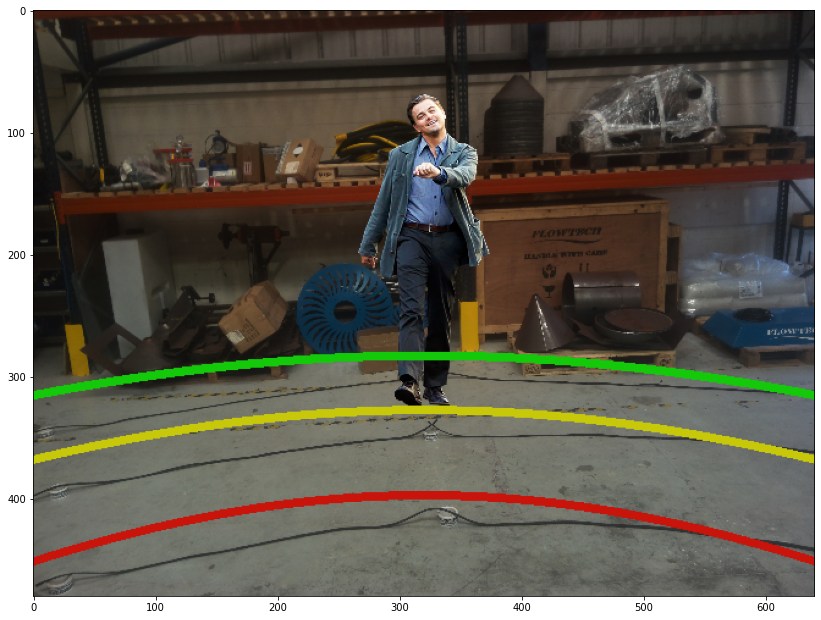

In [6]:
fx, fy, cx, cy, frame_width, frame_height = load_calibration_params(
#             "/Users/vpvp/Documents/work/Ocular_source_code/data/calibration_matrices_2023_v2.npz"
            # "/Users/vpvp/Documents/work/Ocular_source_code/data/camera_calibration_2023.npz"
#     "/Users/vpvp/Documents/work/Ocular_source_code/data/calibration_2023_adjusted.npz"
    "/Users/vpvp/Documents/work/Ocular_source_code/data/july_3.npz"
    # "/Users/vpvp/Documents/work/Ocular_source_code/july_1.npz"
        )
print(fx, fy, cx, cy, frame_width, frame_height)
frame_width, frame_height = 4192, 3120

K = get_K_matrix(
            # (3120, 4192),
            (480, 640),
            (frame_height, frame_width),
            fx * 1,
            fy * 1,
            cx,
            cy,
        )

h = 1.86
angle = transform_to_formula_angle(16)

test_image =cv2.cvtColor(cv2.imread("/Users/vpvp/Documents/work/Ocular_source_code/frames/1.bmp"), cv2.COLOR_BGR2RGB)
test_image = cv2.resize(test_image, (640, 480))

dist = functools.partial(get_distance_to_point, camera_h=h, camera_K=K, alpha=angle)

line_3 = [(x, search_closest_coordinate(frame_height, x, 3, dist)) for x in range(frame_width)]
line_4 = [(x, search_closest_coordinate(frame_height, x, 4, dist)) for x in range(frame_width)] 
line_5 = [(x, search_closest_coordinate(frame_height, x, 5, dist)) for x in range(frame_width)] 

visualization_frame = test_image.copy()

r, y, g = (200, 20, 10), (200, 200, 10), (20, 200, 10)
for line_color, line in zip((r, y, g), [line_3, line_4, line_5]):
    dl = [l for l in line if l[1] is not None]
    cv2.polylines(visualization_frame, [np.array(dl).reshape(-1, 1, 2)], isClosed=False, color=line_color, thickness=5)
    # for i, j in line:
    #     visualization_frame = cv2.circle(visualization_frame, (i, j), 1, line_color, -1)
                    
plt.figure(figsize=(14, 20))
plt.imshow(visualization_frame)
plt.show()

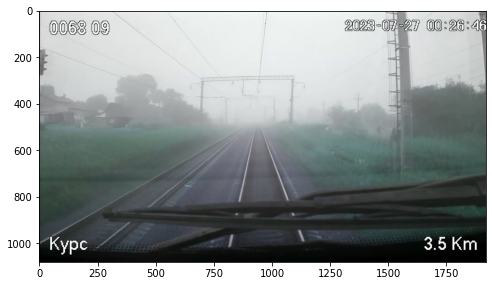

In [51]:
vpath = "/Users/vpvp/Downloads/train_dataset_Безопасный маршрут/основная/00_26_43.mp4"

stream = cv2.VideoCapture(vpath, cv2.CAP_FFMPEG)

for _ in range(5):
    grabbed, frame = stream.read()
stream.release()

plt.figure(figsize=(8, 6))
plt.imshow(frame)
plt.show()

957.439704097066 818.3374801467002 2015.8088476763314 1189.9670374007198 3840 2160


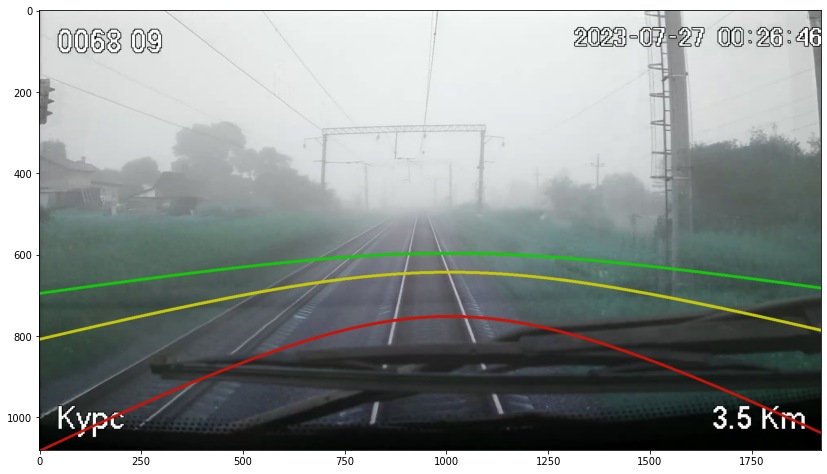

In [49]:
fx, fy, cx, cy, frame_width, frame_height = load_calibration_params(
            "/Users/vpvp/Documents/work/railway_analysis/data/calibration.npz"
        )
print(fx, fy, cx, cy, frame_width, frame_height)
# frame_width, frame_height = 4192, 3120

K = get_K_matrix(
            # (3120, 4192),
            # (480, 640),
            frame.shape[:2],
            (frame_height, frame_width),
            fx * 1,
            fy * 1,
            cx,
            cy,
        )

h = 1.8
angle = transform_to_formula_angle(10)

test_image = frame
# test_image = cv2.resize(test_image, (640, 480))

dist = functools.partial(get_distance_to_point, camera_h=h, camera_K=K, alpha=angle)

line_3 = [(x, search_closest_coordinate(frame_height, x, 3, dist)) for x in range(frame_width)]
line_4 = [(x, search_closest_coordinate(frame_height, x, 6, dist)) for x in range(frame_width)] 
line_5 = [(x, search_closest_coordinate(frame_height, x, 10, dist)) for x in range(frame_width)] 

visualization_frame = test_image.copy()

r, y, g = (200, 20, 10), (200, 200, 10), (20, 200, 10)
for line_color, line in zip((r, y, g), [line_3, line_4, line_5]):
    dl = [l for l in line if l[1] is not None]
    cv2.polylines(visualization_frame, [np.array(dl).reshape(-1, 1, 2)], isClosed=False, color=line_color, thickness=5)
                    
plt.figure(figsize=(14, 20))
plt.imshow(visualization_frame)
plt.show()